In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as sps 
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve 
from sklearn.decomposition import PCA
%matplotlib inline

## Read Data

In [96]:
df = pd.read_csv('NY property data.csv')

In [97]:
df.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,0,0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,0,0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,709,564,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,85,551,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,89,57,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR


In [98]:
df.shape

(1070994, 32)

In [99]:
df.columns

Index(['RECORD', 'BBLE', 'B', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE'],
      dtype='object')

## Fill NA

### 1.  ZIP

In [100]:
df['BLOCK-LOT'] = df['BLOCK'].astype(str) +'-' +df['LOT'].astype(str)
df['ZIP'] = df['ZIP'].astype(str)

In [101]:
fill1 = df.groupby(['BLOCK'])['ZIP'].apply(pd.Series.mode)
fill1 = fill1.to_frame()
fill1 = fill1.reset_index().groupby('BLOCK').agg({'ZIP':'first'})

In [102]:
fill2 = df.groupby(['B'])['ZIP'].apply(pd.Series.mode)
fill2 = fill2.to_frame()
fill2 = fill2.reset_index().groupby('B').agg({'ZIP':'first'})

In [103]:
df = df.set_index('BLOCK')

In [104]:
df['ZIP'] = df['ZIP'].fillna(fill1['ZIP'])
df['ZIP'] = df['ZIP'].replace('nan', np.nan)
df['ZIP'].count()

1041104

In [105]:
df = df.reset_index()

In [106]:
df = df.set_index('B')

In [107]:
df['ZIP'] = df['ZIP'].fillna(fill2['ZIP'])
df['ZIP'] = df['ZIP'].replace('nan', np.nan)

In [108]:
df['ZIP'].count()

1070994

In [109]:
df = df.reset_index()

### 2. FULLVAL, AVLAND, AVTOT

In [110]:
for i in ['FULLVAL', 'AVLAND', 'AVTOT','LTFRONT', 'LTDEPTH', 'BLDFRONT', 'BLDDEPTH', 'STORIES' ]:
    df[i] = df[i].replace(0, np.nan)

In [111]:
df['ZIP-BLDGCL-TAXCLASS'] = df['ZIP'].astype(str) +'-' +df['BLDGCL'].astype(str) +'-' +df['TAXCLASS'].astype(str)

In [112]:
fill3 = df.groupby(['ZIP-BLDGCL-TAXCLASS']).agg({'FULLVAL':'median','AVLAND':'median', 'AVTOT':'median',
        'LTFRONT':'median', 'LTDEPTH':'median', 'BLDFRONT':'median', 'BLDDEPTH':'median', 'STORIES':'median'})
df = df.set_index('ZIP-BLDGCL-TAXCLASS')

In [113]:
for i in ['FULLVAL', 'AVLAND', 'AVTOT','LTFRONT', 'LTDEPTH', 'BLDFRONT', 'BLDDEPTH', 'STORIES' ]:
    df[i] = df[i].fillna(fill3[i])

In [114]:
df['BLDGCL-TAXCLASS'] = df['BLDGCL'].astype(str) +'-' +df['TAXCLASS'].astype(str)

In [115]:
fill4 = df.groupby(['BLDGCL-TAXCLASS']).agg({'FULLVAL':'median', 'AVLAND':'median', 'AVTOT':'median',
        'LTFRONT':'median', 'LTDEPTH':'median', 'BLDFRONT':'median', 'BLDDEPTH':'median', 'STORIES':'median'})
df = df.set_index('BLDGCL-TAXCLASS')

In [116]:
for i in ['FULLVAL', 'AVLAND', 'AVTOT','LTFRONT', 'LTDEPTH', 'BLDFRONT', 'BLDDEPTH', 'STORIES' ]:
    df[i] = df[i].fillna(fill4[i])

In [117]:
fill5 = df.groupby(['TAXCLASS']).agg({'FULLVAL':'median', 'AVLAND':'median', 'AVTOT':'median',
        'LTFRONT':'median', 'LTDEPTH':'median', 'BLDFRONT':'median', 'BLDDEPTH':'median', 'STORIES':'median'})
df = df.set_index('TAXCLASS')

In [118]:
for i in ['FULLVAL', 'AVLAND', 'AVTOT','LTFRONT', 'LTDEPTH', 'BLDFRONT', 'BLDDEPTH', 'STORIES' ]:
    df[i] = df[i].fillna(fill5[i])

In [119]:
df = df.reset_index()
df.head()

,TAXCLASS,B,BLOCK,RECORD,BBLE,LOT,EASEMENT,OWNER,BLDGCL,LTFRONT,...,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,BLOCK-LOT
0,4,1,1,1,1000010101,101,NaN,U S GOVT LAND & BLDGS,P7,500.0,...,66.0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,1-101
1,4,1,1,2,1000010201,201,NaN,U S GOVT LAND & BLDGS,Z9,27.0,...,227.0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,1-201
2,4,1,2,3,1000020001,1,NaN,DEPT OF GENERAL SERVI,Y7,709.0,...,564.0,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,2-1
3,4,1,2,4,1000020023,23,NaN,DEPARTMENT OF BUSINES,T2,793.0,...,551.0,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,2-23
4,4,1,3,5,1000030001,1,NaN,PARKS AND RECREATION,Q1,323.0,...,57.0,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,3-1


In [120]:
df[['ZIP','FULLVAL', 'AVLAND', 'AVTOT','LTFRONT', 'LTDEPTH', 'BLDFRONT', 'BLDDEPTH', 'STORIES' ]].count()

ZIP         1070994
FULLVAL     1070994
AVLAND      1070994
AVTOT       1070994
LTFRONT     1070994
LTDEPTH     1070994
BLDFRONT    1070994
BLDDEPTH    1070994
STORIES     1070994
dtype: int64

## Variable Creation

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070994 entries, 0 to 1070993
Data columns (total 33 columns):
TAXCLASS     1070994 non-null object
B            1070994 non-null int64
BLOCK        1070994 non-null int64
RECORD       1070994 non-null int64
BBLE         1070994 non-null object
LOT          1070994 non-null int64
EASEMENT     4636 non-null object
OWNER        1039249 non-null object
BLDGCL       1070994 non-null object
LTFRONT      1070994 non-null float64
LTDEPTH      1070994 non-null float64
EXT          354305 non-null object
STORIES      1070994 non-null float64
FULLVAL      1070994 non-null float64
AVLAND       1070994 non-null float64
AVTOT        1070994 non-null float64
EXLAND       1070994 non-null float64
EXTOT        1070994 non-null float64
EXCD1        638488 non-null float64
STADDR       1070318 non-null object
ZIP          1070994 non-null object
EXMPTCL      15579 non-null object
BLDFRONT     1070994 non-null float64
BLDDEPTH     1070994 non-null float64

In [122]:
df['lotarea'] = df['LTFRONT'] * df['LTDEPTH']
df['bldarea'] = df['BLDFRONT'] * df['BLDDEPTH']
df['bldvol'] = df['bldarea'] * df['STORIES']

In [123]:
df['FV1'] =  df['FULLVAL'] /  df['lotarea']
df['FV2'] =  df['FULLVAL'] /  df['bldarea']
df['FV3'] = df['FULLVAL'] /  df['bldvol']

In [124]:
df['AL1'] =  df['AVLAND'] /  df['lotarea']
df['AL2'] =  df['AVLAND'] /  df['bldarea']
df['AL3'] = df['AVLAND'] /  df['bldvol']

In [125]:
df['VT1'] =  df['AVTOT'] /  df['lotarea']
df['VT2'] =  df['AVTOT'] /  df['bldarea']
df['VT3'] = df['AVTOT'] /  df['bldvol']

In [126]:
df['ZIP3'] = df['ZIP'].astype(str).str[:3]

In [127]:
l = ['lotarea','bldarea','bldvol','FV1','FV2','FV3','AL1','AL2','AL3','VT1','VT2','VT3']

In [128]:
group1 = df.groupby('ZIP3')[l].mean()
name1 = []
for i in l:
    name1.append(i+'-1')
group1.columns = name1
group1 = group1.reset_index()

In [129]:
group2 = df.groupby('ZIP')[l].mean()
name2 = []
for i in l:
    name2.append(i+'-2')
group2.columns = name2
group2 = group2.reset_index()

In [130]:
group3 = df.groupby('TAXCLASS')[l].mean()
name3 = []
for i in l:
    name3.append(i+'-3')
group3.columns = name3
group3 = group3.reset_index()

In [131]:
group4 = df.groupby('BLDGCL')[l].mean()
name4 = []
for i in l:
    name4.append(i+'-4')
group4.columns = name4
group4 = group4.reset_index()

In [132]:
group5 = df.groupby('B')[l].mean()
name5 = []
for i in l:
    name5.append(i+'-5')
group5.columns = name5
group5 = group5.reset_index()

In [133]:
df = pd.merge(df,group1, how = 'left', on = 'ZIP3')
df = pd.merge(df,group2, how = 'left', on = 'ZIP')
df = pd.merge(df,group3, how = 'left', on = 'TAXCLASS')
df = pd.merge(df,group4, how = 'left', on = 'BLDGCL')
df = pd.merge(df,group5, how = 'left', on = 'B')

In [134]:
for x in l:
    for i in range(5):
        new_col = x + '-d-' + str(i+1)  ## meaning x divided by 1
        denominator = x+'-'+str(i+1)
        df[new_col] = df[x]/df[denominator]

In [135]:
list(df.columns)

['TAXCLASS',
 'B',
 'BLOCK',
 'RECORD',
 'BBLE',
 'LOT',
 'EASEMENT',
 'OWNER',
 'BLDGCL',
 'LTFRONT',
 'LTDEPTH',
 'EXT',
 'STORIES',
 'FULLVAL',
 'AVLAND',
 'AVTOT',
 'EXLAND',
 'EXTOT',
 'EXCD1',
 'STADDR',
 'ZIP',
 'EXMPTCL',
 'BLDFRONT',
 'BLDDEPTH',
 'AVLAND2',
 'AVTOT2',
 'EXLAND2',
 'EXTOT2',
 'EXCD2',
 'PERIOD',
 'YEAR',
 'VALTYPE',
 'BLOCK-LOT',
 'lotarea',
 'bldarea',
 'bldvol',
 'FV1',
 'FV2',
 'FV3',
 'AL1',
 'AL2',
 'AL3',
 'VT1',
 'VT2',
 'VT3',
 'ZIP3',
 'lotarea-1',
 'bldarea-1',
 'bldvol-1',
 'FV1-1',
 'FV2-1',
 'FV3-1',
 'AL1-1',
 'AL2-1',
 'AL3-1',
 'VT1-1',
 'VT2-1',
 'VT3-1',
 'lotarea-2',
 'bldarea-2',
 'bldvol-2',
 'FV1-2',
 'FV2-2',
 'FV3-2',
 'AL1-2',
 'AL2-2',
 'AL3-2',
 'VT1-2',
 'VT2-2',
 'VT3-2',
 'lotarea-3',
 'bldarea-3',
 'bldvol-3',
 'FV1-3',
 'FV2-3',
 'FV3-3',
 'AL1-3',
 'AL2-3',
 'AL3-3',
 'VT1-3',
 'VT2-3',
 'VT3-3',
 'lotarea-4',
 'bldarea-4',
 'bldvol-4',
 'FV1-4',
 'FV2-4',
 'FV3-4',
 'AL1-4',
 'AL2-4',
 'AL3-4',
 'VT1-4',
 'VT2-4',
 'VT3-4',
 '

In [136]:
len(df.columns)

166

In [137]:
new_col = ['FV1-d-1',
 'FV1-d-2',
 'FV1-d-3',
 'FV1-d-4',
 'FV1-d-5',
 'FV2-d-1',
 'FV2-d-2',
 'FV2-d-3',
 'FV2-d-4',
 'FV2-d-5',
 'FV3-d-1',
 'FV3-d-2',
 'FV3-d-3',
 'FV3-d-4',
 'FV3-d-5',
 'AL1-d-1',
 'AL1-d-2',
 'AL1-d-3',
 'AL1-d-4',
 'AL1-d-5',
 'AL2-d-1',
 'AL2-d-2',
 'AL2-d-3',
 'AL2-d-4',
 'AL2-d-5',
 'AL3-d-1',
 'AL3-d-2',
 'AL3-d-3',
 'AL3-d-4',
 'AL3-d-5',
 'VT1-d-1',
 'VT1-d-2',
 'VT1-d-3',
 'VT1-d-4',
 'VT1-d-5',
 'VT2-d-1',
 'VT2-d-2',
 'VT2-d-3',
 'VT2-d-4',
 'VT2-d-5',
 'VT3-d-1',
 'VT3-d-2',
 'VT3-d-3',
 'VT3-d-4',
 'VT3-d-5']

In [138]:
len(new_col)

45

In [139]:
newdf = df[new_col]
newdf.head()

,FV1-d-1,FV1-d-2,FV1-d-3,FV1-d-4,FV1-d-5,FV2-d-1,FV2-d-2,FV2-d-3,FV2-d-4,FV2-d-5,...,VT2-d-1,VT2-d-2,VT2-d-3,VT2-d-4,VT2-d-5,VT3-d-1,VT3-d-2,VT3-d-3,VT3-d-4,VT3-d-5
0,0.110585,0.122245,0.182677,0.043861,0.113224,14.439563,16.215731,9.557154,4.149549,14.860993,...,23.609295,17.131699,9.485691,4.149549,24.581057,18.804996,10.793297,4.395877,4.232819,19.824151
1,109.597100,121.153525,181.046247,532.335049,112.213371,38.533786,43.273712,25.504465,21.885579,39.658423,...,63.004366,45.718086,25.313755,21.885577,65.597633,58.547405,33.603812,13.686107,8.612672,61.720440
2,0.707531,0.782137,1.168789,1.683213,0.724421,0.437199,0.490977,0.289370,0.043961,0.449959,...,0.714838,0.518711,0.287206,0.043961,0.744261,0.664270,0.381264,0.155281,0.026803,0.700271
3,0.242462,0.268028,0.400529,0.312146,0.248250,1.397755,1.569689,0.925136,1.056686,1.438549,...,2.285388,1.658355,0.918218,1.056686,2.379455,3.185578,1.828391,0.744664,0.603871,3.358224
4,1.808243,1.998913,2.987083,2.435037,1.851409,89.639261,100.665519,59.329790,3.751952,92.255449,...,146.563975,106.351748,58.886151,3.751951,152.596565,408.587889,234.512715,95.511966,4.292062,430.731719


In [140]:
newdf.shape

(1070994, 45)

In [141]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1070994 entries, 0 to 1070993
Data columns (total 45 columns):
FV1-d-1    1070994 non-null float64
FV1-d-2    1070994 non-null float64
FV1-d-3    1070994 non-null float64
FV1-d-4    1070994 non-null float64
FV1-d-5    1070994 non-null float64
FV2-d-1    1070994 non-null float64
FV2-d-2    1070994 non-null float64
FV2-d-3    1070994 non-null float64
FV2-d-4    1070994 non-null float64
FV2-d-5    1070994 non-null float64
FV3-d-1    1070994 non-null float64
FV3-d-2    1070994 non-null float64
FV3-d-3    1070994 non-null float64
FV3-d-4    1070994 non-null float64
FV3-d-5    1070994 non-null float64
AL1-d-1    1070994 non-null float64
AL1-d-2    1070994 non-null float64
AL1-d-3    1070994 non-null float64
AL1-d-4    1070994 non-null float64
AL1-d-5    1070994 non-null float64
AL2-d-1    1070994 non-null float64
AL2-d-2    1070994 non-null float64
AL2-d-3    1070994 non-null float64
AL2-d-4    1070994 non-null float64
AL2-d-5    1070994 non-

## Z-scale

In [142]:
scaler = StandardScaler()
data = scaler.fit_transform(newdf.to_numpy())
data = pd.DataFrame(data, columns = newdf.columns)
data.head()

,FV1-d-1,FV1-d-2,FV1-d-3,FV1-d-4,FV1-d-5,FV2-d-1,FV2-d-2,FV2-d-3,FV2-d-4,FV2-d-5,...,VT2-d-1,VT2-d-2,VT2-d-3,VT2-d-4,VT2-d-5,VT3-d-1,VT3-d-2,VT3-d-3,VT3-d-4,VT3-d-5
0,-0.089476,-0.182207,-0.141101,-0.177126,-0.060434,1.100397,1.661441,0.354087,0.501229,1.070055,...,0.656469,0.932809,0.345259,0.426468,0.539922,0.451410,0.498693,0.042385,0.469796,0.416346
1,10.924910,24.941876,31.082765,98.430509,7.579251,3.073170,4.615965,1.013971,3.323794,2.984393,...,1.800320,2.585807,0.989258,2.828035,1.479056,1.458999,1.660249,0.158338,1.106279,1.342993
2,-0.029422,-0.045225,0.029139,0.126566,-0.018781,-0.046081,-0.055581,-0.029405,-0.152147,-0.042463,...,-0.008280,-0.027830,-0.029002,-0.129454,-0.005856,-0.008512,-0.031507,-0.010543,-0.141426,-0.006629
3,-0.076209,-0.151945,-0.103491,-0.127426,-0.051232,0.032567,0.062206,-0.003098,0.009021,0.033856,...,0.037322,0.038069,-0.003327,0.007676,0.031585,0.055411,0.042183,-0.003187,-0.057566,0.052158
4,0.081310,0.207358,0.343045,0.265842,0.058024,7.257555,10.882709,2.413630,0.437954,7.044833,...,4.226504,6.091926,2.355223,0.372631,3.471022,10.333575,11.890914,1.179621,0.478405,9.504655


In [143]:
data.columns

Index(['FV1-d-1', 'FV1-d-2', 'FV1-d-3', 'FV1-d-4', 'FV1-d-5', 'FV2-d-1',
       'FV2-d-2', 'FV2-d-3', 'FV2-d-4', 'FV2-d-5', 'FV3-d-1', 'FV3-d-2',
       'FV3-d-3', 'FV3-d-4', 'FV3-d-5', 'AL1-d-1', 'AL1-d-2', 'AL1-d-3',
       'AL1-d-4', 'AL1-d-5', 'AL2-d-1', 'AL2-d-2', 'AL2-d-3', 'AL2-d-4',
       'AL2-d-5', 'AL3-d-1', 'AL3-d-2', 'AL3-d-3', 'AL3-d-4', 'AL3-d-5',
       'VT1-d-1', 'VT1-d-2', 'VT1-d-3', 'VT1-d-4', 'VT1-d-5', 'VT2-d-1',
       'VT2-d-2', 'VT2-d-3', 'VT2-d-4', 'VT2-d-5', 'VT3-d-1', 'VT3-d-2',
       'VT3-d-3', 'VT3-d-4', 'VT3-d-5'],
      dtype='object')

In [144]:
data.shape

(1070994, 45)

In [145]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070994 entries, 0 to 1070993
Data columns (total 45 columns):
FV1-d-1    1070994 non-null float64
FV1-d-2    1070994 non-null float64
FV1-d-3    1070994 non-null float64
FV1-d-4    1070994 non-null float64
FV1-d-5    1070994 non-null float64
FV2-d-1    1070994 non-null float64
FV2-d-2    1070994 non-null float64
FV2-d-3    1070994 non-null float64
FV2-d-4    1070994 non-null float64
FV2-d-5    1070994 non-null float64
FV3-d-1    1070994 non-null float64
FV3-d-2    1070994 non-null float64
FV3-d-3    1070994 non-null float64
FV3-d-4    1070994 non-null float64
FV3-d-5    1070994 non-null float64
AL1-d-1    1070994 non-null float64
AL1-d-2    1070994 non-null float64
AL1-d-3    1070994 non-null float64
AL1-d-4    1070994 non-null float64
AL1-d-5    1070994 non-null float64
AL2-d-1    1070994 non-null float64
AL2-d-2    1070994 non-null float64
AL2-d-3    1070994 non-null float64
AL2-d-4    1070994 non-null float64
AL2-d-5    1070994 non-

## PCA

In [163]:
pca = PCA(n_components =5)
pc = pca.fit_transform(data)
pca_data = pd.DataFrame(data = pc)

In [164]:
pca.explained_variance_ratio_

array([0.41470264, 0.22209106, 0.10806754, 0.06873016, 0.05391089])

In [165]:
sum(pca.explained_variance_ratio_)

0.8675022794508433

In [166]:
pca_data.shape

(1070994, 5)

In [167]:
pca_data.head()

,0,1,2,3,4
0,2.732942,-0.856048,-0.940361,-0.742155,-0.623999
1,22.225932,88.918363,-13.007838,50.930956,-43.288784
2,-0.163558,0.222272,0.303070,0.048150,-0.043248
3,0.124580,-0.271099,0.108991,-0.166599,-0.014666
4,37.656657,-5.534121,6.249843,-7.307947,-13.037839


## Z-scale

In [168]:
scaler = StandardScaler()
normalized_pca_data = scaler.fit_transform(pca_data.to_numpy())
normalized_pca_data = pd.DataFrame(normalized_pca_data, columns = pca_data.columns)
normalized_pca_data.head()

,0,1,2,3,4
0,0.632639,-0.270786,-0.426423,-0.422002,-0.400626
1,5.144999,28.126757,-5.898631,28.960223,-27.792709
2,-0.037861,0.070309,0.137433,0.027379,-0.027766
3,0.028839,-0.085754,0.049424,-0.094731,-0.009416
4,8.717001,-1.750560,2.834101,-4.155425,-8.370687


## S1

In [169]:
s1_list = []
for row in normalized_pca_data.values:
    s1 =math.sqrt(sum([i*i for i in row]))
    s1_list.append(s1)
normalized_pca_data['s1'] = s1_list 

In [170]:
normalized_pca_data.head()

,0,1,2,3,4,s1
0,0.632639,-0.270786,-0.426423,-0.422002,-0.400626,0.996986
1,5.144999,28.126757,-5.898631,28.960223,-27.792709,49.633744
2,-0.037861,0.070309,0.137433,0.027379,-0.027766,0.163662
3,0.028839,-0.085754,0.049424,-0.094731,-0.009416,0.140324
4,8.717001,-1.750560,2.834101,-4.155425,-8.370687,13.206766


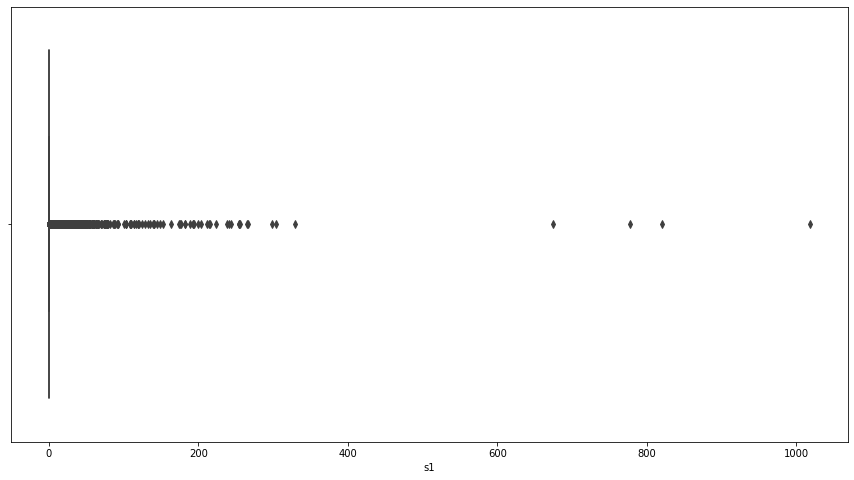

In [171]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='s1', data=normalized_pca_data)

<function matplotlib.pyplot.show(*args, **kw)>

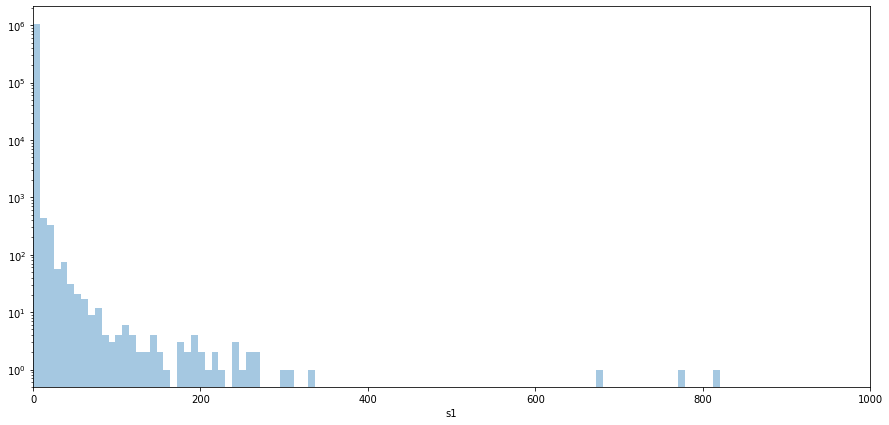

In [172]:
plt.figure(figsize=(15, 7))
xhigh=1000
plt.xlim(0,xhigh)
temp = normalized_pca_data[normalized_pca_data["s1"]<xhigh]
ax = sns.distplot(temp['s1'],bins=100, kde=False)
ax.set_yscale('log')
plt.show

## Autoencoder

In [173]:
small_s1 = normalized_pca_data[normalized_pca_data["s1"]<=1]
del small_s1["s1"]

In [174]:
X_train, X_test = train_test_split(small_s1, test_size=0.2, random_state=37)

In [175]:
data_in = Input(shape=(X_train.shape[1],))

encoded = Dense(3,activation='tanh')(data_in)

decoded = Dense(5,activation='tanh')(encoded)

autoencoder = Model(inputs=data_in,outputs=decoded)

autoencoder.compile(optimizer='adam',loss='mean_squared_error', 
                    metrics=['accuracy'])

In [176]:
autoencoder.fit(X_train, X_train, epochs = 16, batch_size=64, validation_data=(X_test,X_test))

Train on 844670 samples, validate on 211168 samples
Epoch 1/16
844670/844670 [==============================] - 16s 19us/step - loss: 6.4735e-04 - accuracy: 0.8690 - val_loss: 3.8666e-04 - val_accuracy: 0.9031
Epoch 2/16
844670/844670 [==============================] - 15s 18us/step - loss: 3.9213e-04 - accuracy: 0.9030 - val_loss: 3.8443e-04 - val_accuracy: 0.9047
Epoch 3/16
844670/844670 [==============================] - 18s 21us/step - loss: 3.9020e-04 - accuracy: 0.9032 - val_loss: 3.8584e-04 - val_accuracy: 0.9024
Epoch 4/16
844670/844670 [==============================] - 17s 20us/step - loss: 3.8956e-04 - accuracy: 0.9028 - val_loss: 3.8134e-04 - val_accuracy: 0.9027
Epoch 5/16
844670/844670 [==============================] - 16s 19us/step - loss: 3.8916e-04 - accuracy: 0.9029 - val_loss: 3.8124e-04 - val_accuracy: 0.9031
Epoch 6/16
844670/844670 [==============================] - 16s 19us/step - loss: 3.8890e-04 - accuracy: 0.9029 - val_loss: 3.8057e-04 - val_accuracy: 0.9010


In [177]:
pca_result = normalized_pca_data.drop(["s1"],axis=1)
X = pca_result.values
prediction = autoencoder.predict(X)

## S2

In [178]:
s2_list=[]
for i in range(len(prediction)):
    s2 = 0
    for j in range(len(prediction[i])):
        s2 = (X[i][j]-prediction[i][j])**2+s2
    s2 = math.sqrt(s2)
    s2_list.append(s2)
    
normalized_pca_data["s2"] = s2_list

In [179]:
normalized_pca_data.head()

,0,1,2,3,4,s1,s2
0,0.632639,-0.270786,-0.426423,-0.422002,-0.400626,0.996986,0.855104
1,5.144999,28.126757,-5.898631,28.960223,-27.792709,49.633744,48.123019
2,-0.037861,0.070309,0.137433,0.027379,-0.027766,0.163662,0.011439
3,0.028839,-0.085754,0.049424,-0.094731,-0.009416,0.140324,0.098277
4,8.717001,-1.750560,2.834101,-4.155425,-8.370687,13.206766,13.100645


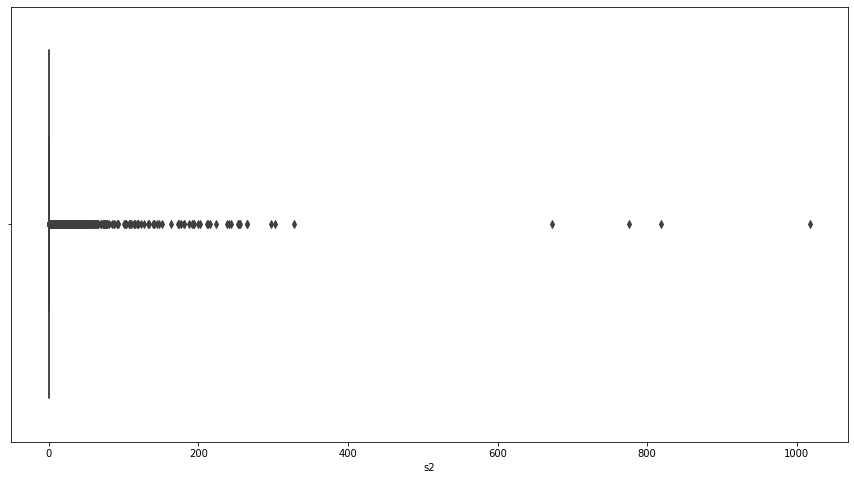

In [180]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='s2', data=normalized_pca_data)

<function matplotlib.pyplot.show(*args, **kw)>

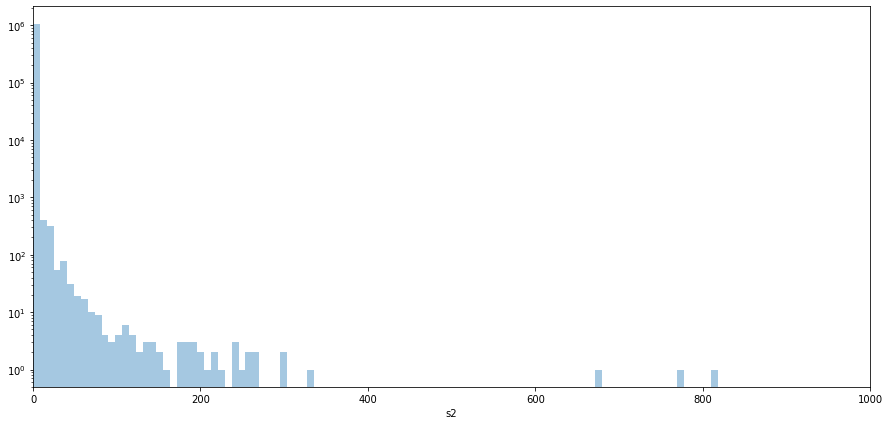

In [185]:
plt.figure(figsize=(15, 7))
xhigh=1000
plt.xlim(0,xhigh)
temp = normalized_pca_data[normalized_pca_data["s2"]<xhigh]
ax = sns.distplot(temp['s2'],bins=100, kde=False)
ax.set_yscale('log')
plt.show

## S

In [197]:
normalized_pca_data['s1_rank'] = normalized_pca_data["s1"].rank(ascending = True)
normalized_pca_data['s2_rank'] = normalized_pca_data["s2"].rank(ascending = True)

In [198]:
normalized_pca_data["s"] = (normalized_pca_data["s1_rank"]+normalized_pca_data["s2_rank"])/2
normalized_pca_data.head()

,0,1,2,3,4,s1,s2,s,s1_rank,s2_rank
0,0.632639,-0.270786,-0.426423,-0.422002,-0.400626,0.996986,0.855104,1060360.5,1055790.0,1064931.0
1,5.144999,28.126757,-5.898631,28.960223,-27.792709,49.633744,48.123019,1070874.0,1070875.0,1070873.0
2,-0.037861,0.070309,0.137433,0.027379,-0.027766,0.163662,0.011439,621982.0,840958.0,403006.0
3,0.028839,-0.085754,0.049424,-0.094731,-0.009416,0.140324,0.098277,899151.0,763725.0,1034577.0
4,8.717001,-1.750560,2.834101,-4.155425,-8.370687,13.206766,13.100645,1070246.0,1070181.0,1070311.0


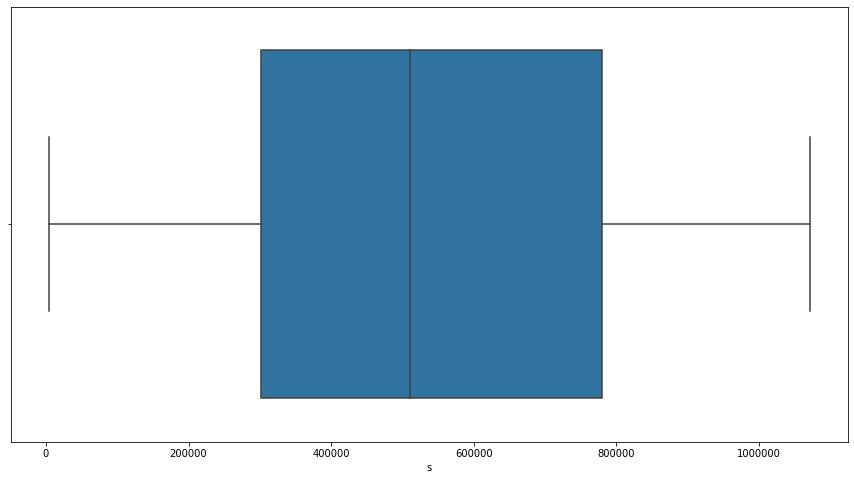

In [199]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='s', data=normalized_pca_data)

<function matplotlib.pyplot.show(*args, **kw)>

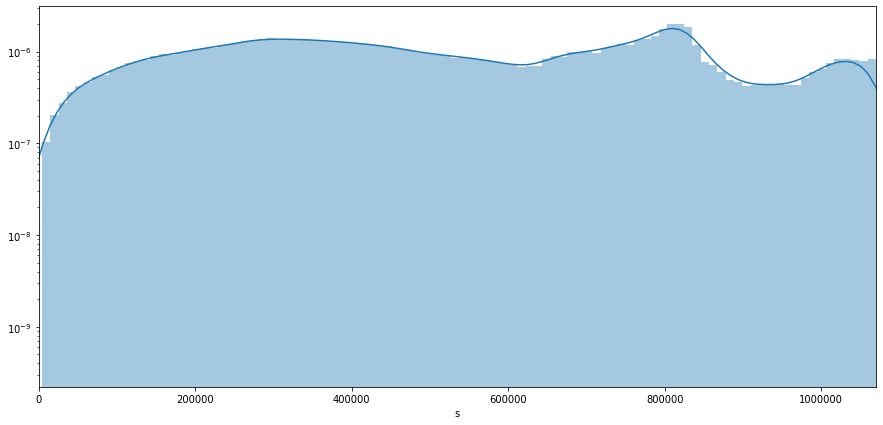

In [211]:
plt.figure(figsize=(15, 7))
xhigh=1070000
plt.xlim(0,xhigh)
temp = normalized_pca_data[normalized_pca_data["s"]<xhigh]
ax = sns.distplot(temp['s'],bins=100, kde=True)
ax.set_yscale('log')
plt.show

## Top 10 by S

In [212]:
normalized_pca_data.nlargest(20, "s", keep='first')

,0,1,2,3,4,s1,s2,s,s1_rank,s2_rank
632815,643.420084,-197.410664,299.385721,548.099302,439.080422,1017.740952,1017.318186,1070994.0,1070994.0,1070994.0
1067359,75.936311,609.526729,-59.368520,430.093151,-326.975130,820.186949,818.651361,1070993.0,1070993.0,1070993.0
776305,75.283985,463.719317,32.980403,-342.624372,515.043596,777.465341,775.845173,1070992.0,1070992.0,1070992.0
565391,289.831238,409.729334,87.257598,-401.424341,182.691214,673.803935,672.206167,1070991.0,1070991.0,1070991.0
920627,129.758256,-39.133180,-298.536848,-23.923100,-3.796519,328.754603,327.695958,1070990.0,1070990.0,1070990.0
915468,65.326666,-20.602924,-285.191243,19.025039,75.560199,303.475526,302.503044,1070989.0,1070989.0,1070989.0
1067000,131.232647,-38.709133,-264.465982,-9.183644,15.994982,298.333436,297.266720,1070988.0,1070988.0,1070988.0
794104,94.290117,-28.124257,-246.471060,-12.961051,15.317432,266.143187,265.104648,1070987.0,1070987.0,1070987.0
293329,135.522977,-23.163577,98.503754,-108.638704,-172.030536,264.580596,264.400761,1070986.0,1070986.0,1070986.0
85885,171.684654,-40.157039,52.599711,-80.660089,-158.757256,256.056349,255.938792,1070985.0,1070985.0,1070985.0


In [213]:
df.loc[[632815,1067359,776305,565391,920627,915468,1067000,794104,293329,85885], :]

,TAXCLASS,B,BLOCK,RECORD,BBLE,LOT,EASEMENT,OWNER,BLDGCL,LTFRONT,...,VT2-d-1,VT2-d-2,VT2-d-3,VT2-d-4,VT2-d-5,VT3-d-1,VT3-d-2,VT3-d-3,VT3-d-4,VT3-d-5
632815,2,4,1842,632816,4018420001,1,NaN,"864163 REALTY, LLC",D9,157.0,...,15686.015803,7458.827938,20939.737597,694.625638,17288.441317,23170.818249,8554.848009,81434.323963,908.838115,30577.013535
1067359,1,5,7853,1067360,5078530085,85,NaN,NaN,B2,1.0,...,0.535518,0.337498,1.004298,1.049661,0.535518,0.417498,0.353475,1.021426,1.062439,0.417498
776305,4,4,8010,776306,4080100001,1,NaN,TONY CHEN,Q9,6.0,...,12.357743,4.342417,2.532355,1.008123,13.620164,18.254413,6.218967,4.107420,1.106630,24.089155
565391,4,3,8590,565392,3085900700,700,NaN,U S GOVERNMENT OWNRD,V9,117.0,...,11842.789738,4844.093744,1486.909399,449.802534,11845.461392,10652.163442,3296.555223,1205.866226,449.802534,10654.683175
920627,1,4,15577,920628,4155770029,29,NaN,"PLUCHENIK, YAAKOV",A1,91.0,...,1049.711978,1665.978271,2457.408893,2234.310919,993.419931,810.241284,1392.233296,2499.318860,2396.636111,878.500674
915468,1B,4,14140,915469,4141400001,1,NaN,UNITED STATES OF AMER,V0,999.0,...,291.088193,298.402986,2275.093845,2490.683439,177.061798,107.824939,81.641541,2121.490642,2490.683439,62.631684
1067000,1,5,7812,1067001,5078120132,132,NaN,"DRANOVSKY, VLADIMIR",A3,96.0,...,2160.373254,1361.525092,4051.515183,2113.707777,2160.373254,1122.840687,950.652364,2747.074595,1568.524412,1122.840687
794104,1,4,8946,794105,4089460045,45,NaN,"HAVEN BUILDERS, INC.",B1,37.0,...,1708.298416,1119.594947,2570.446523,2685.535320,1039.115963,1054.646990,647.946069,1742.856197,1827.813347,612.607046
293329,4,3,1117,293330,3011170001,1,NaN,CITY OF NY/PARKS AND,Q1,526.0,...,4220.660551,3440.681778,529.920735,33.764083,4221.612704,7592.664739,6148.596170,859.519103,38.624579,7594.460758
85885,4,1,1254,85886,1012540010,10,NaN,PARKS AND RECREATION,Q1,4000.0,...,2995.630168,2691.093905,1203.577685,76.686369,3118.930652,8351.153221,3973.677691,1952.175004,87.725726,8803.752322


In [ ]:
original = pd.read_csv('NY property data.csv')

In [ ]:
top10original = original.loc[[], :]
top10original

In [ ]:
top10original.to_excel('top10original.xlsx', index=True, header=True)

In [ ]:
top10original1 = data.loc[[], :]
top10original1

In [ ]:
top10original1.to_excel('top10original1.xlsx', index=True, header=True)

In [ ]:
normalized_pca_data.sort_values(by='s',axis=0,ascending=True).head(10)

In [ ]:
lowest = data.loc[[], :]
lowest

In [ ]:
lowest.to_excel('lowest.xlsx', index=True, header=True)